<center>Учреждение образования</center>
<center>«Белорусский государственный университет информатики и радиоэлектроники»</center>
<br><br>
<center>Кафедра информатики</center>
<br><br><br><br><br><br><br><br><br><br>
<center>Лабораторная работа №8</center>
<center>Выявление аномалий</center>
<br><br><br><br><br><br><br><br>

<p style='text-align: right;'>
Выполнил:
Полевой Александр Вадимович <br>
магистрант кафедры информатики <br>      
группа № 858641	
<br><br><br><br>
Проверил:     Стержанов Максим Валерьевич
</p>

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<center>
Минск 2019
</center>


Набор данных ex8data1.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X1 и X2 - задержка в мс и пропускная способность в мб/c серверов. Среди серверов необходимо выделить те, характеристики которых аномальные. Набор разделен на обучающую выборку (X), которая не содержит меток классов, а также валидационную (Xval, yval), на которой необходимо оценить качество алгоритма выявления аномалий. В метках классов 0 обозначает отсутствие аномалии, а 1, соответственно, ее наличие.

**1. Загрузите данные ex8data1.mat из файла.**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math

data1 = scipy.io.loadmat('data/ex8data1.mat')
X1 = data1['X']
X1_val = data1['Xval']
y1_val = data1['yval']
X1.shape

(307, 2)

**2. Постройте график загруженных данных в виде диаграммы рассеяния.**

In [4]:
def draw_scatter(X):
    plt.figure(figsize=(8,8))
    plt.scatter(X[:,0], X[:,1], s=9, marker='.')
    plt.xlabel('Latency (ms)',fontsize=14)
    plt.ylabel('Throughput (mb/s)',fontsize=14)
    plt.grid(True)

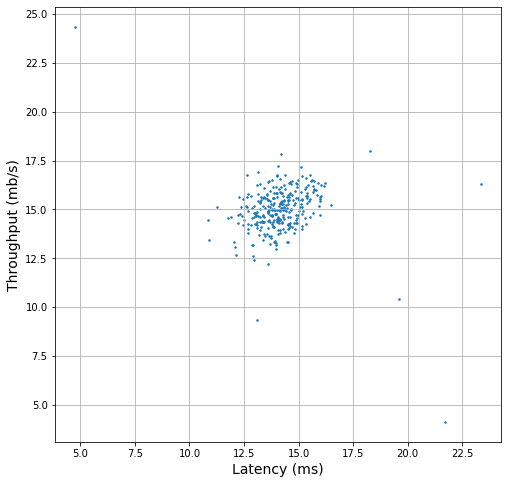

In [5]:
draw_scatter(X1)

**3. Представьте данные в виде двух независимых нормально распределенных случайных величин.**

In [6]:
def draw_histogram(X, title=None):
    plt.figure(figsize=(8,5))
    plt.hist(X, 100)
    if title:
        plt.title(title, fontsize=20)
    plt.grid(True)

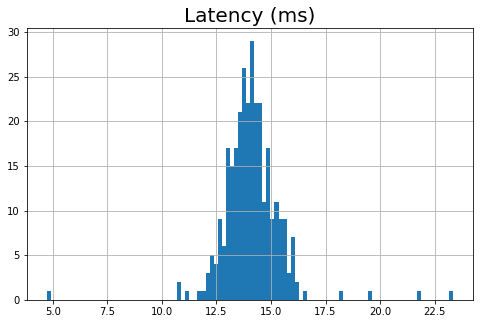

In [7]:
draw_histogram(X1[:, 0], 'Latency (ms)')

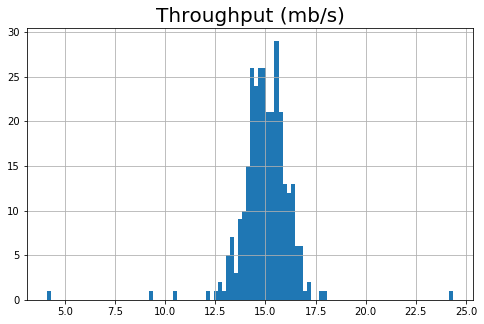

In [8]:
draw_histogram(X1[:,1], 'Throughput (mb/s)')

**4. Оцените параметры распределений случайных величин.**

In [9]:
def get_dist_params(X):
    return np.mean(X, axis=0), np.var(X, axis=0)

In [10]:
mu, sig2 = get_dist_params(X1)

print(f'\u03BC = {mu}')
print(f'\u03C3^2 = {sig2}')

μ = [14.11222578 14.99771051]
σ^2 = [1.83263141 1.70974533]


**5. Постройте график плотности распределения получившейся случайной величины в виде изолиний, совместив его с графиком из пункта 2.**

In [11]:
def p(X, mu, sigma2):
    p1 = 1/ (  np.sqrt( 2 * math.pi) * np.sqrt(sigma2) )
    p2 = ((X - mu) ** 2) / (2 * sigma2)
    result_matrix = p1 * np.exp(-p2)
    
    return np.prod(result_matrix, axis=1).reshape(-1, 1)

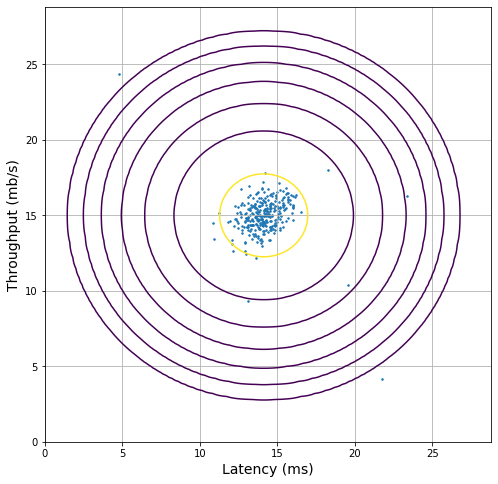

In [12]:
def draw_dist(mu, sigma2):
    grid_params = np.arange(0, 29, 0.2)
    x1, x2 = np.meshgrid(grid_params, grid_params)
    z = np.column_stack([x1.flatten(), x2.flatten()])
    z = p(z, mu, sigma2)
    z = z.reshape(x1.shape)
    levels = [10**exp for exp in range(-20,0,3)]
    plt.contour(x1, x2, z, levels=levels)
    
draw_scatter(X1)
draw_dist(mu, sig2)

**6. Подберите значение порога для обнаружения аномалий на основе валидационной выборки. В качестве метрики используйте F1-меру.**

In [13]:
def f1_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    
    tp = np.sum(np.logical_and((y_true == 1), (y_pred == 1)))
    fp = np.sum(np.logical_and((y_true == 0), (y_pred == 1)))
    fn = np.sum(np.logical_and((y_true == 1), (y_pred == 0)))
    
    if (tp + fp) == 0 or (tp + fn) == 0: return 0
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    result = 2 * (precision * recall) / (precision + recall)
    
    if math.isnan(result):
        result = 0
    
    return result

In [14]:
def find_eps(y_true, p_vals, iterations = 100):
    epsilons = np.linspace(np.max(p_vals), np.min(p_vals), iterations)

    best_f1 = 0
    best_eps = 1
    best_iteration = 0

    for i in range(len(epsilons)):
        eps = epsilons[i]
        y_pred = p_vals < eps
        f1 = float(f1_score(y_true, y_pred))
        if f1 > best_f1:
            best_f1 = f1
            best_eps = eps
            best_iteration = i
            
    return best_eps, best_f1, best_iteration

In [15]:
p_vals = p(X1_val, mu, sig2)
best_eps, best_f1, best_i = find_eps(y1_val, p_vals, 200)

print(f'best_eps: {best_eps}')
print(f'best_f1: {best_f1}')
print(f'best_iteration: {best_i}')

best_eps: 0.00045180164719947624
best_f1: 0.8750000000000001
best_iteration: 198


**7. Выделите аномальные наблюдения на графике из пункта 5 с учетом выбранного порогового значения.**

In [16]:
def highlite_anomalies(X, mu, sig2, eps):
    p_vals = p(X, mu, sig2)
    indices = np.nonzero(p_vals < eps)[0]
    
    anomalies = X[indices]
    plt.scatter(anomalies[:,0], anomalies[:,1], s=150, facecolors='none', edgecolors='r')

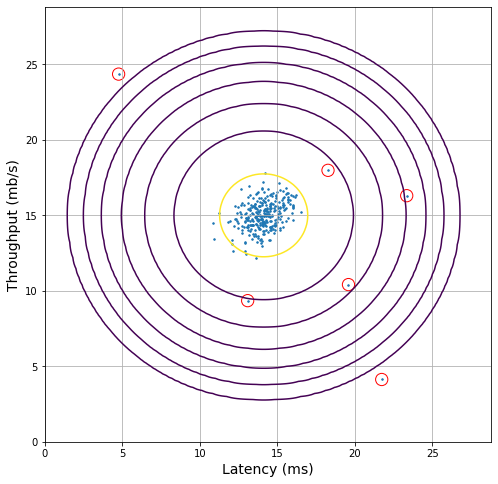

In [17]:
draw_scatter(X1)
draw_dist(mu, sig2)
highlite_anomalies(X1, mu, sig2, best_eps)

Набор данных ex8data2.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 11-мерную переменную X - координаты точек, среди которых необходимо выделить аномальные. Набор разделен на обучающую выборку (X), которая не содержит меток классов, а также валидационную (Xval, yval), на которой необходимо оценить качество алгоритма выявления аномалий.

**8. Загрузите данные ex8data2.mat из файла.**

In [18]:
data2 = scipy.io.loadmat('data/ex8data2.mat')

In [19]:
X2 = data2['X']
X2_val = data2['Xval']
y2_val = data2['yval']
X2.shape

(1000, 11)

**9. Представьте данные в виде 11-мерной нормально распределенной случайной величины.**

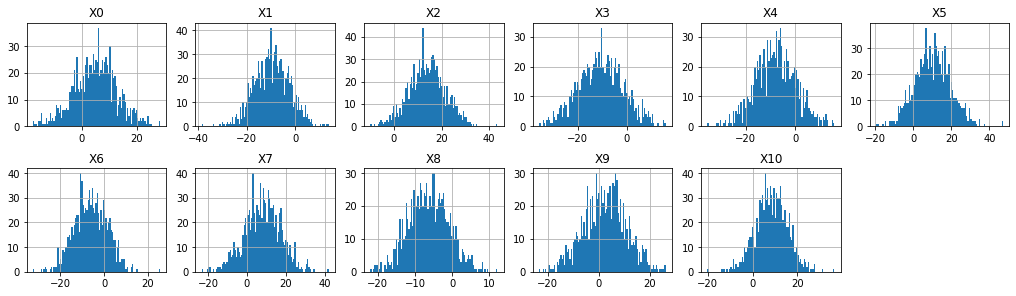

In [20]:
fig1, axes = plt.subplots(ncols=6, nrows=2, constrained_layout=True, figsize=(14, 4))
m, n = X2.shape

axes = axes.flatten()

for i in range(len(axes)):
    ax = axes[i]
    
    if i >= n:
        ax.axis('off')
        continue
    
    ax.hist(X2[:, i], 100)
    ax.set_title(f'X{i}')
    ax.grid(True)

**10. Оцените параметры распределения случайной величины.**

In [21]:
def get_dist_params_multi(X):
    mu = np.mean(X, axis=0)
    sig_p = X - mu
    Sigma = np.dot(sig_p.T, sig_p) / len(X)
    
    return mu , Sigma

In [22]:
mu_2, Sigma_2 = get_dist_params_multi(X2)

In [23]:
import pandas as pd

data = np.column_stack((mu_2, Sigma_2))
df = pd.DataFrame(data)
df.rename(columns={0: '\u03BC', 1: '\u03C3^2'}, inplace=True)
df

,μ,σ^2,2,3,4,5,6,7,8,9,10,11
0,4.939400,60.974894,1.313268,0.692818,0.130233,4.676506,-0.531987,-3.378742,4.941811,-1.154137,3.912468,-2.903585
1,-9.637268,1.313268,53.205722,-2.224656,-4.606173,1.732980,3.079553,1.383449,7.512966,4.194336,-4.825456,7.714638
2,13.814707,0.692818,-2.224656,58.515463,2.623698,3.308372,-3.387748,2.846269,2.175521,7.228553,5.888981,-2.846572
3,-10.464489,0.130233,-4.606173,2.623698,84.204037,1.905289,1.426925,3.763097,2.568146,-4.178290,1.912427,-1.231126
4,-7.956229,4.676506,1.732980,3.308372,1.905289,65.268592,1.183154,5.409526,-2.523786,0.746834,4.012760,-0.517061
5,10.199504,-0.531987,3.079553,-3.387748,1.426925,1.183154,89.574878,2.256491,1.325419,-0.120476,-3.430006,1.274346
6,-6.019408,-3.378742,1.383449,2.846269,3.763097,5.409526,2.256491,55.633499,-1.624894,-1.566798,-1.463391,-5.353484
7,7.969829,4.941811,7.512966,2.175521,2.568146,-2.523786,1.325419,-1.624894,87.162338,3.660373,-1.264235,2.364298
8,-6.253182,-1.154137,4.194336,7.228553,-4.178290,0.746834,-0.120476,-1.566798,3.660373,29.629268,-0.466203,2.343422
9,2.324513,3.912468,-4.825456,5.888981,1.912427,4.012760,-3.430006,-1.463391,-1.264235,-0.466203,70.785205,-0.337962


**11. Подберите значение порога для обнаружения аномалий на основе валидационной выборки. В качестве метрики используйте F1-меру.**

In [24]:
def p_multi(X, mu , Sigma):
    m, n = X.shape
    
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.pinv(Sigma)
    
    e1 = 1 / ( np.power((2 * math.pi), n/2) * np.sqrt(Sigma_det) )

    X_mu = X - mu
    
    e2 = np.exp( - 0.5 * np.sum((np.dot(X_mu, Sigma_inv) * X_mu), axis=1) )
    
    return (e1 * e2).reshape(-1, 1)

In [25]:
p_vals_2 = p_multi(X2_val, mu_2, Sigma_2)

In [26]:
best_eps_2, best_f1_2, best_i_2 = find_eps(y2_val, p_vals_2, 6000)

print(f'best_eps: {best_eps_2}')
print(f'best_f1: {best_f1_2}')
print(f'best_iteration: {best_i_2}')

best_eps: 2.9235687320703794e-19
best_f1: 0.7368421052631577
best_iteration: 5998


**12. Выделите аномальные наблюдения в обучающей выборке. Сколько их было обнаружено? Какой был подобран порог?**

In [27]:
p_vals_2_train = p_multi(X2, mu_2, Sigma_2)
indices = np.nonzero(p_vals_2_train < best_eps_2)[0]
print(f'abnormals found: {len(indices)}')

abnormals found: 48


**Вывод** 

Выявление аномалий - опознавание редких данных, событий или наблюдений, которые вызывают подозрения ввиду существенного отличия от большей части данных. Обычно они превращаются в подвид проблемы, как, например, мошенничество, структурный деффект или ошибки в тексте. 